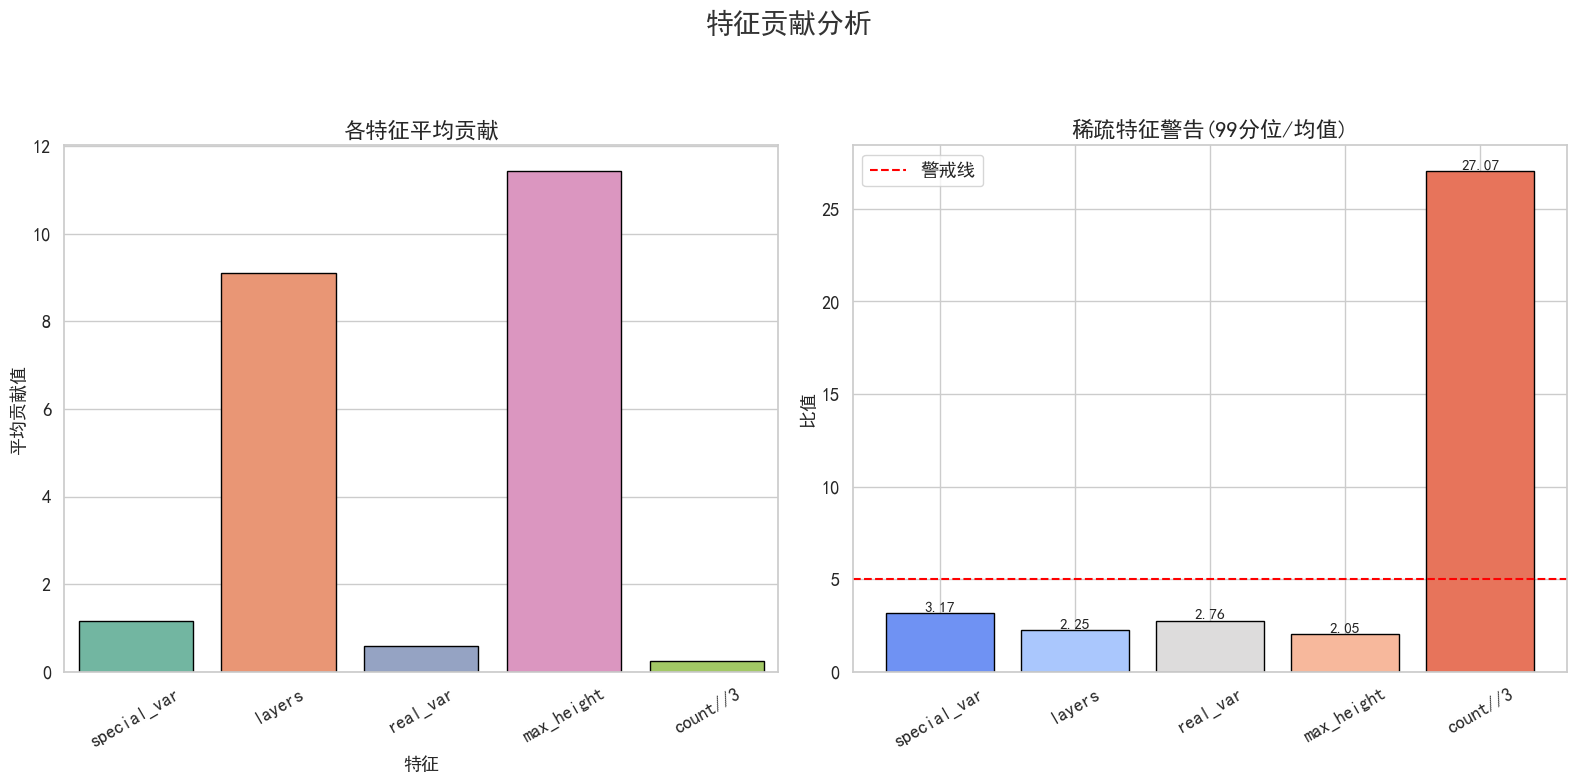

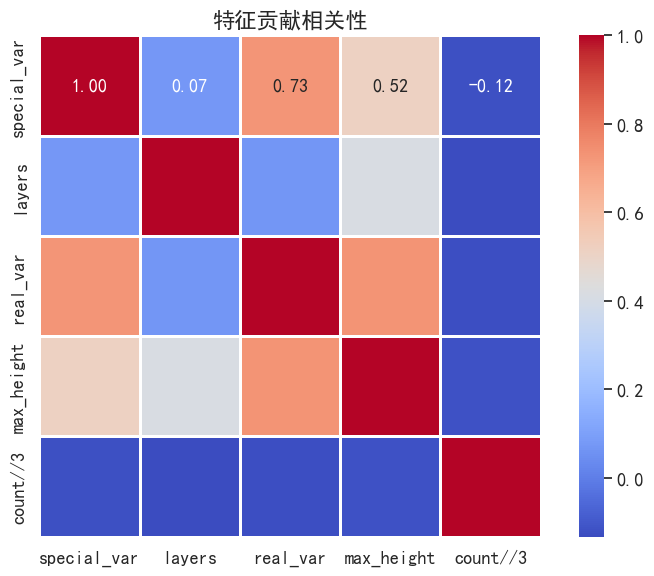

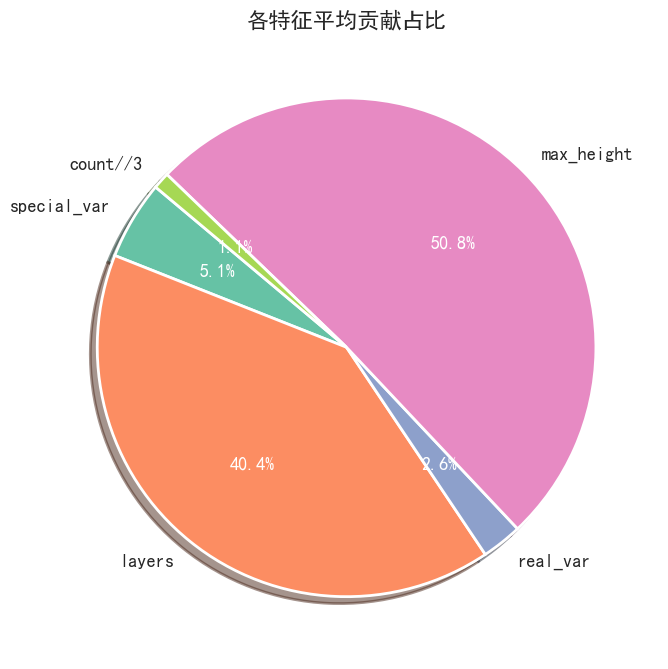

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import re
import matplotlib as mpl

# 设置中文字体和美化风格
sns.set_theme(style="whitegrid", font_scale=1.2)
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False


# ======================
# 数据预处理模块
# ======================
def preprocess_data(raw_df):
    """
    轻量级预处理：
    1. 保留所有原始数据（不删除任何记录）
    2. 仅处理缺失值
    3. 添加异常标记列
    """
    df = raw_df.copy()
    features = ['special_var', 'layers', 'real_var', 'max_height', 'count//3']
    for col in features:
        q1 = df[col].quantile(0.05)
        q3 = df[col].quantile(0.95)
        df[f'{col}_异常'] = (df[col] < q1) | (df[col] > q3)
    return df

def parse_log(log_path):
    """
    日志解析核心函数
    输入示例日志行：
    2025-06-01 13:13:27,228 - INFO - 损失构成: 方差7.56 切变0.30 真方差2.84 最大高度7.00 行消除0.00
    """
    pattern = r"方差([\d.]+)\s+切变([\d.]+)\s+真方差([\d.]+)\s+最大高度([\d.]+)\s+行消除([\d.]+)"
    data = []
    with open(log_path, 'r', encoding='utf-8') as f:
        for line in f:
            match = re.search(pattern, line)
            if match:
                values = [float(x) for x in match.groups()]
                data.append(values)
    columns = ['special_var', 'layers', 'real_var', 'max_height', 'count//3']
    return pd.DataFrame(data, columns=columns)

def plot_analysis(analysis, contributions):
    """生成多维度分析图表（中文显示，1x2 + 1个相关性图，美化）"""
    # 主图：1x2 布局
    plt.figure(figsize=(16, 8))
    palette = sns.color_palette("Set2")
    
    # 图1：平均贡献条形图
    plt.subplot(121)
    sns.barplot(
        x=analysis['mean_contribution'].index,
        y=analysis['mean_contribution'].values,
        palette=palette,
        edgecolor='black'
    )
    plt.title('各特征平均贡献', fontsize=16, fontweight='bold')
    plt.xticks(rotation=30)
    plt.ylabel('平均贡献值', fontsize=13)
    plt.xlabel('特征', fontsize=13)
    
    # 图2：稀疏特征检测
    plt.subplot(122)
    sparse_ratio = (contributions.quantile(0.99) / contributions.abs().mean())
    bars = plt.bar(sparse_ratio.index, sparse_ratio.values, color=sns.color_palette("coolwarm", len(sparse_ratio)), edgecolor='black')
    plt.axhline(5, color='red', linestyle='--', label='警戒线')
    plt.title('稀疏特征警告(99分位/均值)', fontsize=16, fontweight='bold')
    plt.xticks(rotation=30)
    plt.ylabel('比值', fontsize=13)
    plt.legend()
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=11)
    
    plt.suptitle('特征贡献分析', fontsize=20, fontweight='bold', color='#333')
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()
    
    # 单独的相关性热力图
    plt.figure(figsize=(8, 6))
    corr = contributions.corr()
    sns.heatmap(
        corr,
        annot=True,
        cmap='coolwarm',
        fmt='.2f',
        square=True,
        linewidths=1,
        linecolor='white',
        annot_kws={"size": 13, "weight": "bold"}
    )
    plt.title('特征贡献相关性', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # 贡献占比饼图
    plt.figure(figsize=(7, 7))
    contrib_sum = analysis['mean_contribution']
    wedges, texts, autotexts = plt.pie(
        contrib_sum,
        labels=contrib_sum.index,
        autopct='%1.1f%%',
        startangle=140,
        colors=palette,
        shadow=True,
        wedgeprops={'edgecolor': 'white', 'linewidth': 2}
    )
    for autotext in autotexts:
        autotext.set_fontsize(13)
        autotext.set_color('white')
        autotext.set_weight('bold')
    plt.title('各特征平均贡献占比', fontsize=16, fontweight='bold')
    plt.gca().set_aspect('equal')
    plt.tight_layout()
    plt.show()

class FeatureEvaluator:
    def __init__(self, df):
        self.df = df
        self.features =  ['special_var', 'layers', 'real_var', 'max_height', 'count//3']
        # 权重顺序需与特征顺序一致 
        self.weights = np.array([0.4026, 34.1266, 0.2201, 1.6746, 6.594])
        
    def evaluate(self):
        """执行完整分析流程"""
        contributions = self.df[self.features] * self.weights
        total_loss = contributions.sum(axis=1)
        analysis = {
            'mean_contribution': contributions.mean(),
            'contribution_std': contributions.std(),
            'top1%_contribution': contributions.quantile(0.99),
            'kurtosis': contributions.kurtosis()
        }
        return analysis, contributions

if __name__ == '__main__':
    log_path = "game.log"  # 修改为实际路径
    raw_df = parse_log(log_path)
    clean_df = preprocess_data(raw_df)
    evaluator = FeatureEvaluator(clean_df)
    analysis, contributions = evaluator.evaluate()
    plot_analysis(analysis, contributions)